In [1]:
import pandas as pd
import numpy as np
import sklearn
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras

ModuleNotFoundError: No module named 'tensorflow'

In [5]:
pd.set_option('display.float_format', lambda x: '%3f' % x)
covid_df = pd.read_csv("covid-tests-cases-deaths-per-million.csv")

In [69]:
# Acquire USA dataset, remove uneeded columns
US_df = covid_df[covid_df["Entity"] == "United States"]
del US_df["total_tests_per_thousand Annotations"], US_df["Entity"], US_df["Code"], US_df["Date"]

# Add new columns and reformat old ones
USA_pop = 328200000
US_df = US_df.fillna(0)
US_df["new tests per thousand"] = US_df["total_tests_per_thousand"] - US_df["total_tests_per_thousand"].shift(1)
US_df["new confirmed cases per million people"] = US_df["Total confirmed cases of COVID-19 per million people"] - US_df["Total confirmed cases of COVID-19 per million people"].shift(1)
US_df["new confirmed deaths per million people"] = US_df["Total confirmed deaths due to COVID-19 per million people"] - US_df["Total confirmed deaths due to COVID-19 per million people"].shift(1)
US_df["total confirmed cases"] = US_df["Total confirmed cases of COVID-19 per million people"] * USA_pop / 1000000
US_df["total confirmed deaths"] = US_df["Total confirmed deaths due to COVID-19 per million people"] * USA_pop / 1000000
US_df["total confirmed deaths"] = US_df["total confirmed deaths"].round(0)
US_df["total confirmed cases"] = US_df["total confirmed cases"].round(0)
US_df["new confirmed cases"] = US_df["total confirmed cases"] - US_df["total confirmed cases"].shift(1)
US_df["new deaths"] = US_df["total confirmed deaths"] - US_df["total confirmed deaths"].shift(1)
US_df["day"] = np.arange(len(US_df))


US_df = US_df[US_df["day"] < 360]

US_df = US_df.fillna(0)
US_df.reset_index(drop=True, inplace=True)
US_df.head(1000)

,total_tests_per_thousand,Total confirmed cases of COVID-19 per million people,Total confirmed deaths due to COVID-19 per million people,new tests per thousand,new confirmed cases per million people,new confirmed deaths per million people,total confirmed cases,total confirmed deaths,new confirmed cases,new deaths,day
0,0.000000,0.003000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0
1,0.000000,0.003000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1
2,0.000000,0.006000,0.000000,0.000000,0.003000,0.000000,2.000000,0.000000,1.000000,0.000000,2
3,0.000000,0.006000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,3
4,0.000000,0.015000,0.000000,0.000000,0.009000,0.000000,5.000000,0.000000,3.000000,0.000000,4
...,...,...,...,...,...,...,...,...,...,...,...
355,808.429000,68348.006000,1136.979000,3.978000,644.418000,6.061000,22431816.000000,373157.000000,211498.000000,1990.000000,355
356,813.399000,69029.037000,1150.459000,4.970000,681.031000,13.480000,22655330.000000,377581.000000,223514.000000,4424.000000,356
357,817.739000,69724.397000,1162.432000,4.340000,695.360000,11.973000,22883547.000000,381510.000000,228217.000000,3929.000000,357
358,821.479000,70436.056000,1174.302000,3.740000,711.659000,11.870000,23117114.000000,385406.000000,233567.000000,3896.000000,358


In [70]:
#TODO: Clean up dataset(fix NaN, empty spaces, type errors), add columns for new cases, new deaths
#TODO: Reformat dataset for RNN model with 1 week of data on X-axis and new cases/deaths on Y-axis after that week

In [71]:
US_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 11 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   total_tests_per_thousand                                   360 non-null    float64
 1   Total confirmed cases of COVID-19 per million people       360 non-null    float64
 2   Total confirmed deaths due to COVID-19 per million people  360 non-null    float64
 3   new tests per thousand                                     360 non-null    float64
 4   new confirmed cases per million people                     360 non-null    float64
 5   new confirmed deaths per million people                    360 non-null    float64
 6   total confirmed cases                                      360 non-null    float64
 7   total confirmed deaths                                     360 non-null    float64
 8   new confir

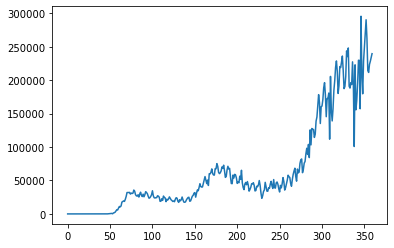

In [72]:
plt.figure()
plt.plot(US_df["day"], US_df["new confirmed cases"])

In [88]:
# Set up time series for RNN/LSTM input
def build_timeseries(dataframe, lookback, col):
    xData, yData = [], []
    tempX = dataframe.copy()
    tempY = tempX.pop(col)
    for i in range(len(dataframe)-lookback-1):
        x = dataframe.values[i:(i+lookback)]
        y = tempY.values[i+lookback]
        xData.append(x)
        yData.append(y)
    return np.array(xData), np.array(yData)

In [111]:
# Split data into Train/Validation/Test
splitTr = int(0.7 * len(US_df))
splitVal = int(0.85 * len(US_df))

train = US_df[:splitTr]
val = US_df[splitTr:splitVal]
test = US_df[splitVal:]

# how many prior days to look at when making a prediction
timestep = 7

# xData is in shape (number of instances, timesteps, features per instance)
xTr, yTr = build_timeseries(train, timestep, "new confirmed cases")
xVal, yVal = build_timeseries(val, timestep, "new confirmed cases")
xTest, yTest = build_timeseries(test, timestep, "new confirmed cases")

In [113]:
# Start building the modoel

model = Sequential()

NameError: name 'Sequential' is not defined